In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
import sys
sys.version
path = sys.path[0] + '/'
path

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/'

In [3]:
cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [4]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    return data.dropna()

In [5]:
def plot_chart(data, n, ticker, save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(path + ticker + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [6]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
df = None
indices = set([])

for stock in stocks.keys():
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

df.head()

,open,high,low,close,volume
2018-06-27,1092.489990,1097.069995,1073.389990,1078.849994,8963932.6
2017-02-20,947.954980,963.011987,942.180981,955.010004,4642169.2
2020-02-17,1215.290009,1222.009996,1192.340001,1195.450026,32065387.4
2019-11-13,1233.569991,1248.440005,1222.180003,1234.930020,73664457.4
2013-07-03,603.965201,609.428787,595.621397,602.930807,6749830.4


In [7]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [8]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2018-06-27,1092.489990,1097.069995,1073.389990,1078.849994,8963932.6
1,2017-02-20,947.954980,963.011987,942.180981,955.010004,4642169.2
2,2020-02-17,1215.290009,1222.009996,1192.340001,1195.450026,32065387.4
3,2019-11-13,1233.569991,1248.440005,1222.180003,1234.930020,73664457.4
4,2013-07-03,603.965201,609.428787,595.621397,602.930807,6749830.4


In [9]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-14 00:00:00'))

In [10]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
14,2012-06-18,498.057199,502.561600,487.347800,493.955995,8785219.8
53,2012-07-13,490.439191,493.975806,486.837798,491.024208,5019317.4
68,2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6
85,2012-10-09,557.985001,567.155396,553.209207,562.510596,4753175.4
48,2012-11-21,577.022601,582.085199,573.131593,576.784399,4711780.2
...,...,...,...,...,...,...
25,2020-09-21,1312.539990,1323.019985,1279.590039,1288.570019,36742844.6
92,2020-11-02,1257.089994,1266.670020,1200.479996,1216.299982,29597068.8
13,2020-11-03,1223.809980,1247.899989,1212.319986,1231.910016,31062702.0
95,2020-12-02,1366.569980,1389.010011,1349.450011,1380.459977,84070260.4


,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2012-08-02,515.080199,519.618190,507.422594,515.838405,3220042.2,3.165544,-0.362080,3.527625,505.899880,500.317539,64.838114,11.590482
2012-08-03,512.061009,516.168790,507.133200,513.588004,5201908.4,3.573758,0.425087,3.148670,506.527801,500.866452,62.135523,11.407990
2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6,4.832759,1.306622,3.526138,509.333039,501.820465,69.587327,11.649705
2012-08-07,527.209999,541.242604,524.404599,533.880203,8202085.0,6.402930,2.325883,4.077047,512.916179,502.921892,73.279433,12.020298
2012-08-08,534.225198,540.492406,530.710211,537.157410,6856643.8,7.821583,3.425023,4.396560,516.860921,504.172926,74.636409,11.860433


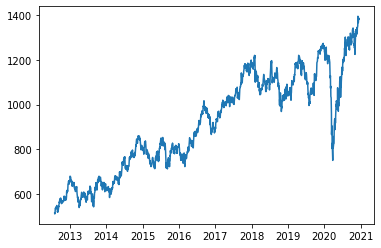

In [11]:
if "Date" in df.columns:
    df.sort_values("Date", inplace=True)
    df= df.set_index("Date")
#     df.index = df.index.sort_values()
    split_date = '2020-01-01'

    df = get_indicators(df)
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]
    df_data_test = df[df.index >= split_date]
    
plt.plot(df.index,df["open"])

df.head()

In [12]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
Date,,,,,,,,,,,,
2012-08-02,515.080199,519.618190,507.422594,515.838405,3220042.2,3.165544,-0.362080,3.527625,505.899880,500.317539,64.838114,11.590482
2012-08-03,512.061009,516.168790,507.133200,513.588004,5201908.4,3.573758,0.425087,3.148670,506.527801,500.866452,62.135523,11.407990
2012-08-06,519.479205,528.380006,518.205194,525.871790,9010146.6,4.832759,1.306622,3.526138,509.333039,501.820465,69.587327,11.649705
2012-08-07,527.209999,541.242604,524.404599,533.880203,8202085.0,6.402930,2.325883,4.077047,512.916179,502.921892,73.279433,12.020298
2012-08-08,534.225198,540.492406,530.710211,537.157410,6856643.8,7.821583,3.425023,4.396560,516.860921,504.172926,74.636409,11.860433


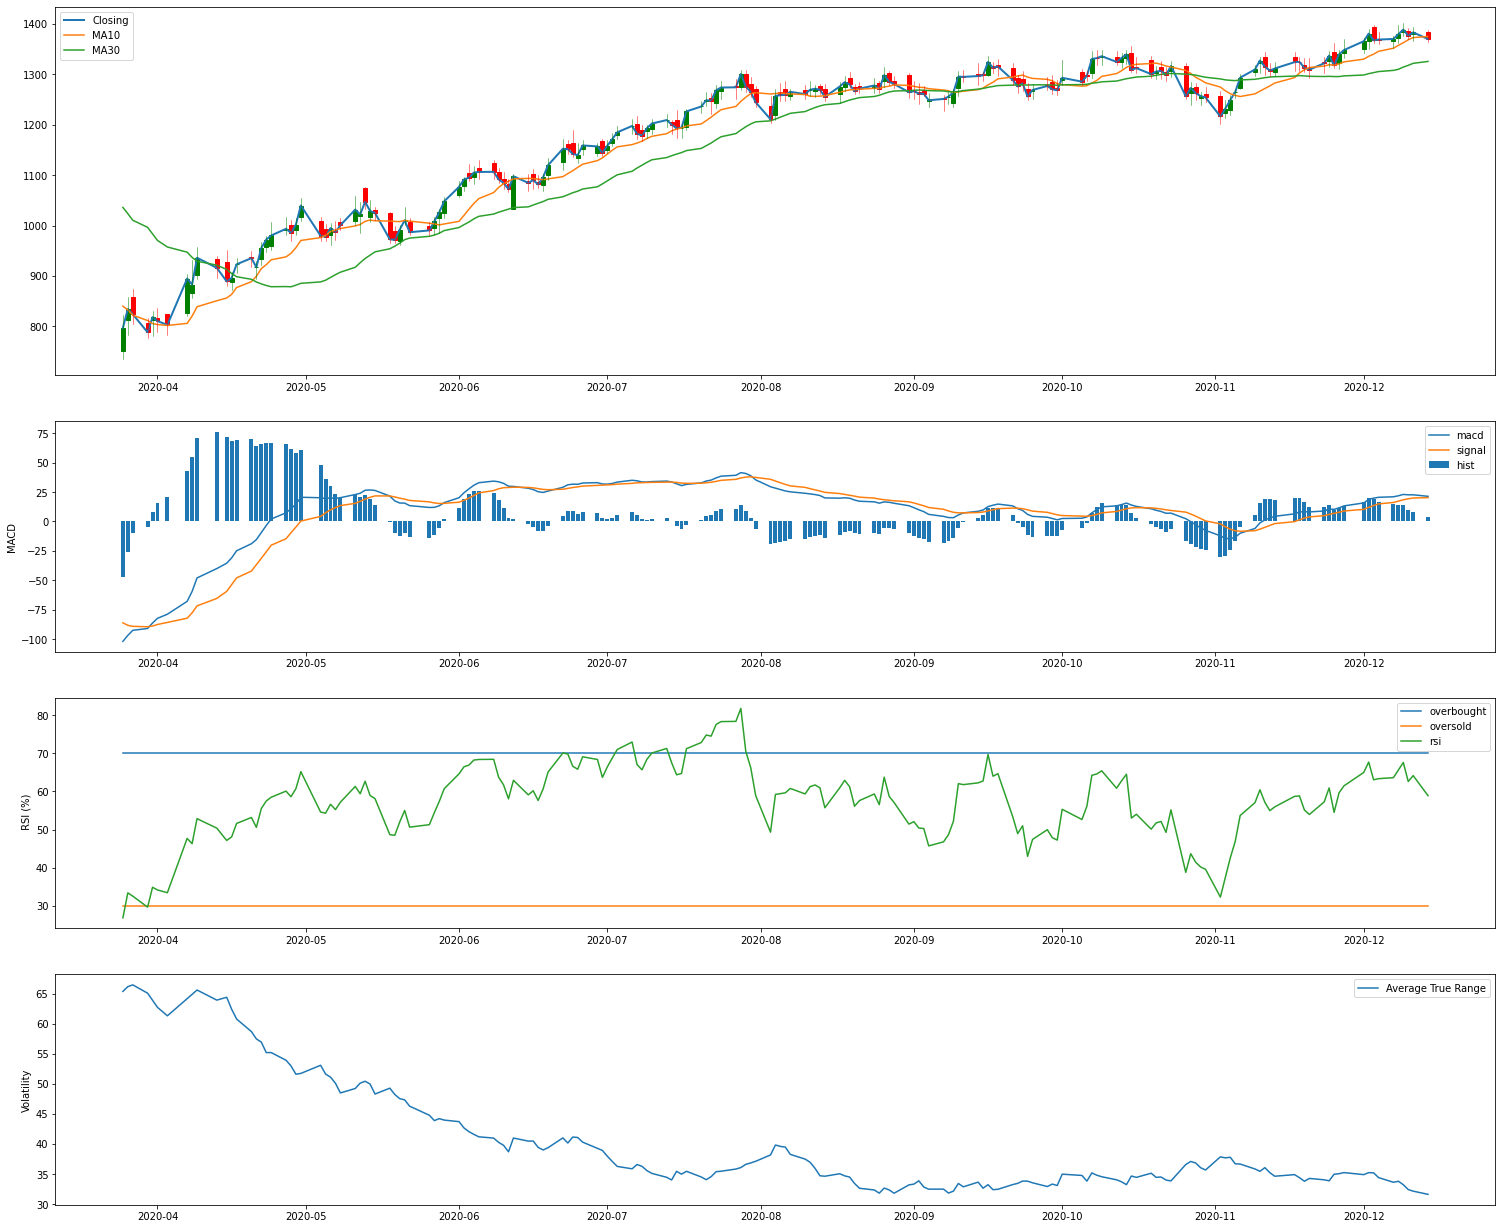

In [13]:
# _df = df.set_index("Date")
_df = get_indicators(df)
plot_chart(_df, 180, 'Custom')

In [14]:
df_data_training.head()
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

Training Size : 1818, Test Size : 238


In [15]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

In [16]:
scaler = MinMaxScaler()
training_Dataset = scaler.fit_transform(data_training)
training_Dataset.shape

(1818, 12)

In [17]:
training_window = 60
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1758, 60, 12), Shape of Y is : (1758,)


In [19]:
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of data_training.index (1758,)


In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 1e-03:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [21]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,12)),
    Dropout(0.2),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.2),
    LSTM(units=70, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           63840     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [23]:
model_name = path + "daily_predictor.hdf5"
# model.save(model_name)
model.load_weights(model_name)

In [24]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=10, callbacks = CustomCallback())

Epoch 1/10
55/55 [==============================] - 5s 98ms/step - loss: 5.1056
Epoch 2/10
55/55 [==============================] - 5s 94ms/step - loss: 0.0012
Epoch 3/10
55/55 [==============================] - 5s 95ms/step - loss: 0.0012
Epoch 4/10
55/55 [==============================] - 5s 94ms/step - loss: 0.0013
Epoch 5/10
55/55 [==============================] - 5s 98ms/step - loss: 0.0013
Epoch 6/10
55/55 [==============================] - 5s 99ms/step - loss: 0.0014
Epoch 7/10
55/55 [==============================] - 5s 97ms/step - loss: 0.0012
Epoch 8/10
55/55 [==============================] - 5s 99ms/step - loss: 0.0012
Epoch 9/10
55/55 [==============================] - 5s 98ms/step - loss: 0.0011
Epoch 10/10
55/55 [==============================] - 5s 98ms/step - loss: 0.0012


In [25]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred.shape
# data_test.head()

55/55 [==============================] - 1s 25ms/step - loss: 0.0041


(1758, 1)

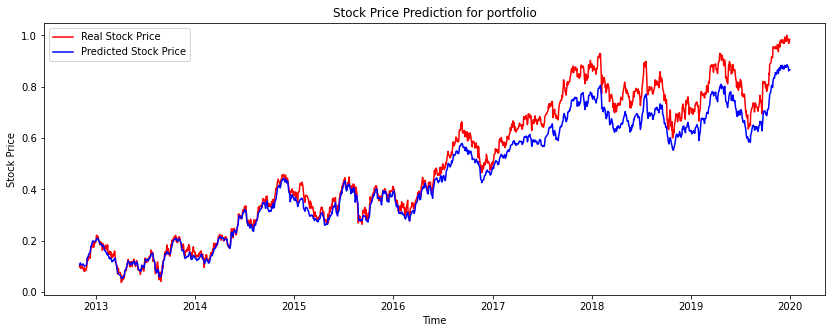

In [26]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window:],y_train, color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window:], test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [27]:
past_60_days = df_data_training.tail(60)

In [28]:

df = past_60_days.append(df_data_test, ignore_index = True)
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR
0,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373
1,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703
2,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080
3,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576
4,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678


In [29]:
inputs = scaler.transform(df)
# inputs

In [30]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((238, 60, 12), (238,))

In [31]:
y_pred = model.predict(X_test)
y_pred.shape

(238, 1)

In [32]:
scaler.scale_

array([1.31394133e-03, 1.31188622e-03, 1.31190584e-03, 1.32336053e-03,
       5.35152474e-09, 1.50747610e-02, 1.64865880e-02, 4.72964823e-02,
       1.32570768e-03, 1.32790464e-03, 1.68015821e-02, 3.95524000e-02])

In [33]:
scale = 1/scaler.scale_[0]
scale

761.0689895629883

In [34]:
y_pred = y_pred*scale
y_test = y_test*scale
y_pred.shape

(238, 1)

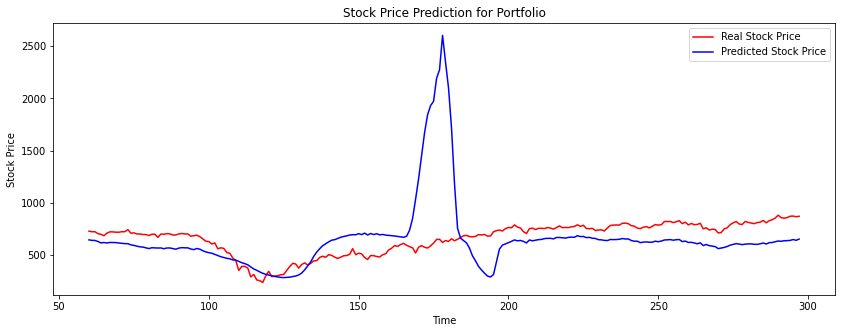

In [35]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df.index[training_window:], y_test, color = 'red', label = 'Real Stock Price')
plt.plot(df.index[training_window:], y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,2000)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()